In [ ]:
import sys
import gc

import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split

In [ ]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
sub = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
org_train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')

daigtv2 = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv", sep=',')
RDizzl3_seven_v1 = pd.read_csv("/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v1.csv")

# TASK 이해하기
학생이 쓴 에세이와 다양한 LLMs가 생성한 에세이를 혼합한 데이터셋에서 에세이가 학생에 의해 쓰였는지, 아니면 LLM에 의해 쓰였는지를 정확하게 감지할 수 있는 모델 만들기

## 사용한 데이터 및 참고자료


## 데이터 이해하기
대회에서 제공한 데이터셋들g)

* sample_submission : 제출 파일
* test_essays : 테스트 데이터
* train_essays : 학습 데이터 (0은 사람이 작성한 essay, 1은 LLMs가 생성한 essay)
* train_prompts : prompts, instruction 정보

### 데이터 분포 확인하기
* 학생 0 label과 LLM 1 label의 클래스 비율을 확인 (학습 데이터셋에서 학생이 작성한 에세이와 LLM이 생성한 에세이 간의 균형)

In [ ]:
# Distribution of the 'generated' column
org_train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

* 학생이 작성한 essay 0 은 1375개, LLM이 작성한 essay 1 은 3개입니다.

In [ ]:
llm_generat_cnt = org_train[org_train['generated'] == 1]['prompt_id'].value_counts()
llm_generat_cnt

prompt_id
1    2
0    1
Name: count, dtype: int64

* 특정 프롬프트에서 LLM이 생성한 essay가 집중적으로 나타나는지 확인해주었습니다. (총3개임)

### 학생과 LLM 생성 essay를 구분하기 위한 특징 찾기
* 길이
* 텍스트 빈도수

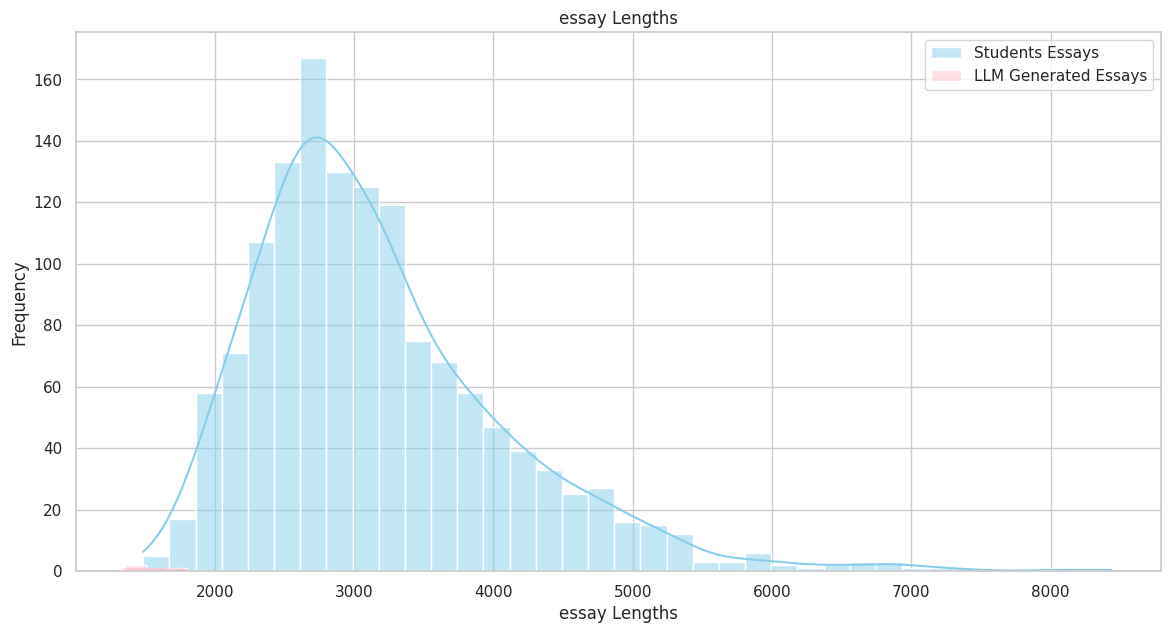

In [ ]:
# text의 길이를 계산해 새로운 essay_length에 저장
org_train['essay_length'] = org_train['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# 학생 essays 길이 분포
sns.histplot(org_train[org_train['generated'] == 0]['essay_length'], color="skyblue", label='Students Essays', kde=True)

# LLM generated essays 길이 분포
sns.histplot(org_train[org_train['generated'] == 1]['essay_length'], color="pink", label='LLM Generated Essays', kde=True)

plt.title('essay Lengths')
plt.xlabel('essay Lengths')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* 그렇지만, 그래프를 딱 보았을 때 LLM이 더 적은 길이로 essay를 작성한다는 사실을 도출할 수 있었습니다.

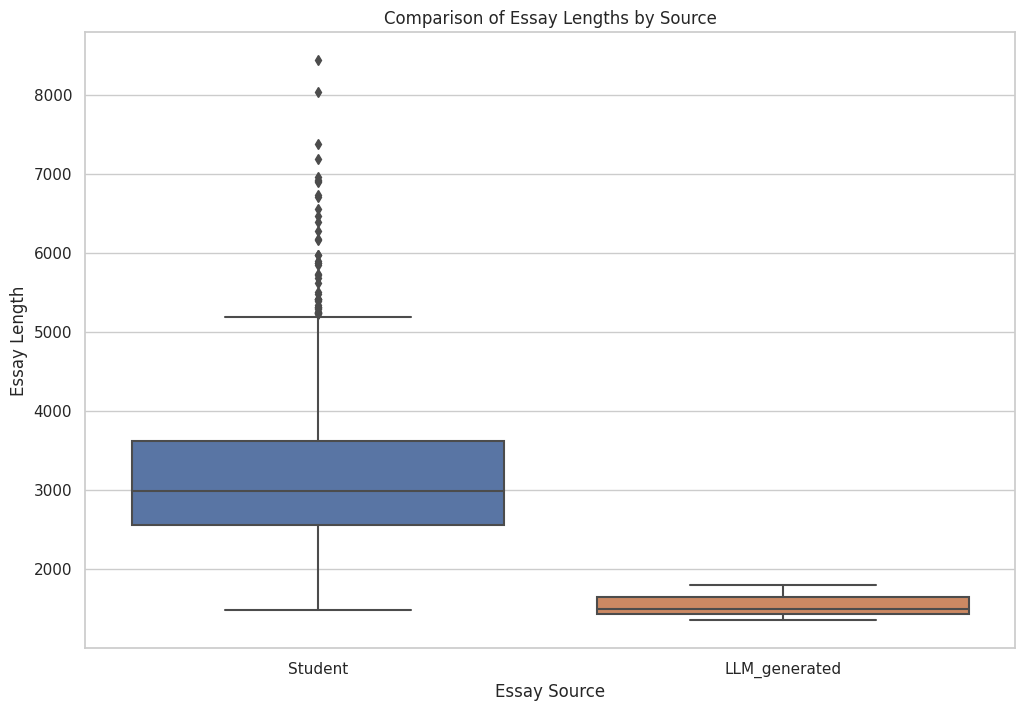

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='generated', y='essay_length', data=org_train)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student', 'LLM_generated'])
plt.show()

* 에세이 길이가 각 그룹 간에 어떻게 분포되는지 한눈에 확인할 수 있었습니다.

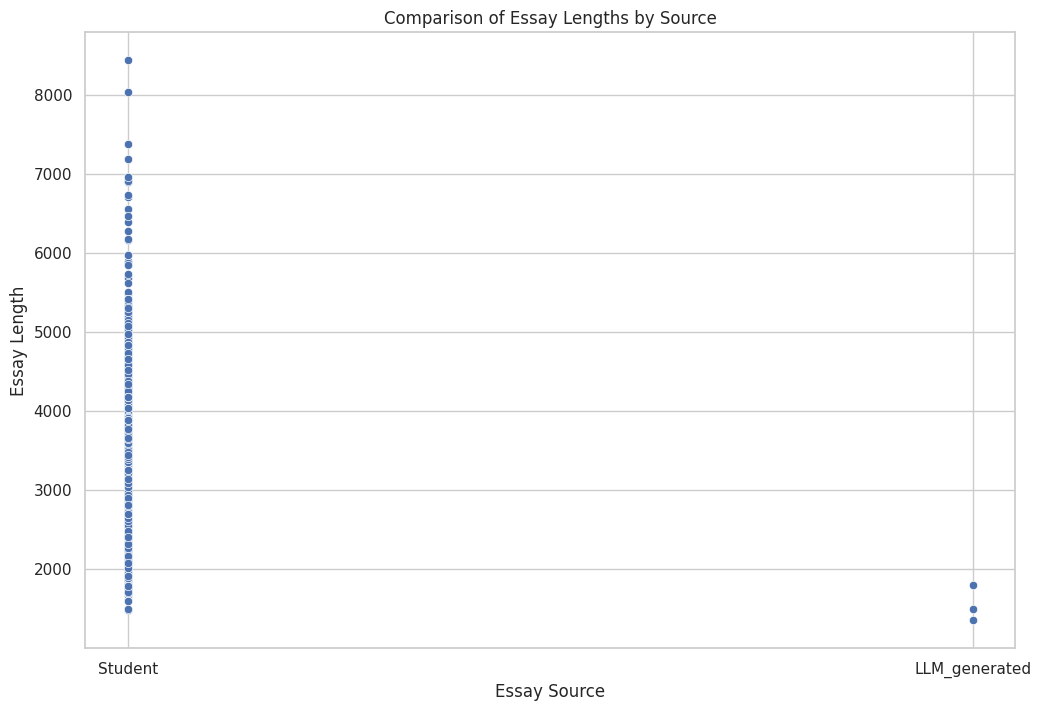

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='generated', y='essay_length', data=org_train)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student', 'LLM_generated'])
plt.show()

* 각 점은 에세이 하나를 나타내며, 0, 1 간의 에세이 길이 차이를 시각적으로 확인할 수 있습니다.

* 텍스트에서 가장 많이 등장하는 단어를 시각화
* 이를 통해 학생이 작성한 에세이와 LLM이 생성한 에세이에서 자주 등장하는 단어들을 비교

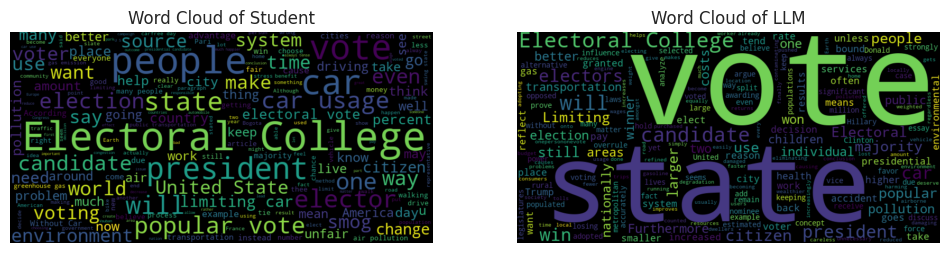

In [ ]:
text_student = ' '.join(org_train[org_train['generated']==0]['text'])
text_llm = ' '.join(org_train[org_train['generated']==1]['text'])

wordcloud_student = WordCloud(width=800, height=400, background_color='black').generate(text_student)
wordcloud_llm = WordCloud(width=800, height=400, background_color='black').generate(text_llm)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_student, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Student')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_llm, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of LLM')

plt.show()

* 학생 에세이는 단어 수가 더 다양하고, 그에 비해 LLM 생성 에세이는 상대적으로 단어수가 적음을 보여줍니다.

* student의 워드 클라우드를 보면, 단어들의 크기가 비슷하고 눈에 띄는 단어가 많지 않습니다.
* LLM의 워드 클라우드를 보면, 눈에 띄는 단어가 뚜렷하게 보였습니다.

* 왜일까? 하는 생각을 해본 결과, student의 에세이는 다양한 표현과 구어적인 특성 때문에 단어들이 고르게 분포하고 눈에 띄는 단어가 적게 나타난다고 생각하며 반면에 LLM은 보다 정형화된 문체와 규칙적인 단어 사용을 기반으로 하기 때문에 특정 단어가 두드러지게 나타난다고 생각했습니다.

## 추가 데이터셋
대회에서 제공한 데이터셋 외에 추가 데이터셋을 사용해주었습니다.

* **DAIGT | External Dataset**
* id: 각 텍스트에 대한 고유 식별자
* text: FeedBack Prize 3 대회에서 추출된 학생이 작성한 텍스트로, 학생이 쓴 텍스트로 활용 가능
* instructions: ChatGPT(LLM)에게 텍스트를 생성하기 위한 명령어
* source_text: ChatGPT(LLM)가 생성한 AI 텍스트

In [ ]:
external_df = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv", sep=',')
print(external_df.shape)
external_df = external_df.rename(columns={'generated': 'label'})
external_df = external_df[["source_text"]]
external_df.columns = ["text"]
external_df['text'] = external_df['text'].str.replace('\n', '')
external_df["label"] = 1

external_df2 = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv", sep=',')
print(external_df2.shape)
external_df2 = external_df2.rename(columns={'generated': 'label'})
external_df2 = external_df2[["text"]]
external_df2.columns = ["text"]
external_df2['text'] = external_df2['text'].str.replace('\n', '')
external_df2["label"] = 0

(2421, 4)
(2421, 4)


In [ ]:
external_df = pd.concat([external_df2, external_df])

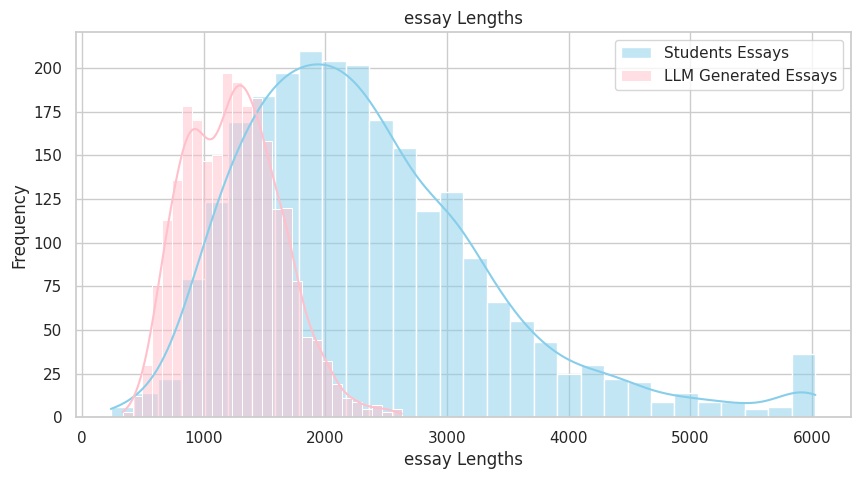

In [ ]:
external_df['essay_length'] = external_df['text'].apply(len)

sns.set(style="whitegrid", palette="deep")
plt.figure(figsize=(10, 5))

sns.histplot(external_df[external_df['label']==0]['essay_length'], color="skyblue", label='Students Essays', kde=True)
sns.histplot(external_df[external_df['label']==1]['essay_length'], color="pink", label='LLM Generated Essays', kde=True)

plt.title('essay Lengths')
plt.xlabel('essay Lengths')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* 추가 데이터에 대해서도 어떤 집단이 더 많은 단어(길이)를 사용했는지 확인해주었습니다.
*
추가 데이터에도는제공된 데이터와  비슷한 모습이 보입니다.

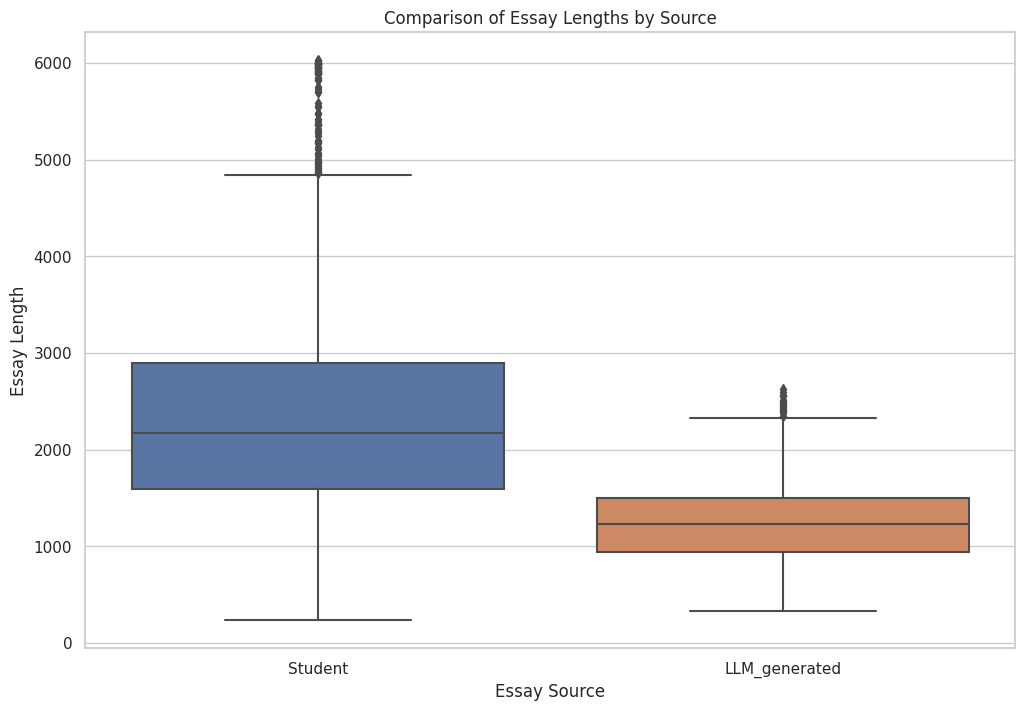

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='essay_length', data=external_df)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student', 'LLM_generated'])
plt.show()

* 분포도 유사한 것을 확인할 수 있었습니다.

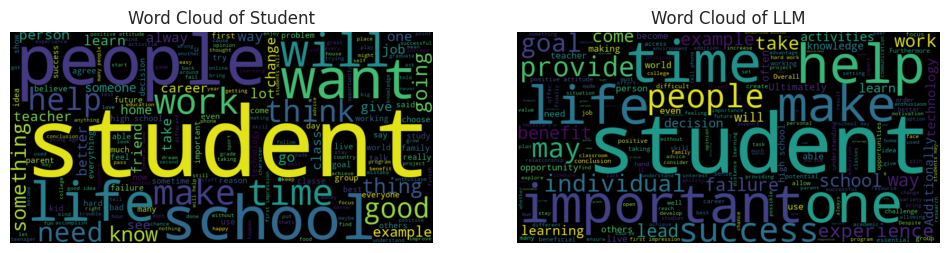

In [ ]:
text_student = ' '.join(external_df[external_df['label']==0]['text'])
text_llm = ' '.join(external_df[external_df['label']==1]['text'])

wordcloud_student = WordCloud(width=800, height=400, background_color='black').generate(text_student)
wordcloud_llm = WordCloud(width=800, height=400, background_color='black').generate(text_llm)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_student, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Student')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_llm, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of LLM')

plt.show()

* 워드클라우드도 비교하기 위해 사용해주었습니다.
*
그런데이 데이터에서는  student가 더 눈에 띄는 단어가 많았기 때문에,  데이터 결과와 차이가 있다는 것을 인지했습니다.
*  
따라서 이 EDA 결과(단어 빈도)에 반영하지 않았습니다.

* **LLM: 7 prompt training dataset**
* 4개의 버전 존재
* 여러 코드를 본 결과,train_essays_RDizzl3_seven_v1.csv를 많이 사용하여 가져왔습니ng)

In [ ]:
print(RDizzl3_seven_v1.tail())
print(RDizzl3_seven_v1.head())

                                                    text  label
15866  While some find the "Face on Mars" imaged by t...      1
15867  Limiting car usage has many benefits for moder...      1
15868  The Rise of Driverless Cars\n\nThe development...      1
15869  The Open Sea Beckons\n\nThe Seagoing Cowboys p...      1
15870  While technology often progresses society in p...      1
                                                text  label
0  Cars. Cars have been around since they became ...      0
1  Transportation is a large necessity in most co...      0
2  "America's love affair with it's vehicles seem...      0
3  How often do you ride in a car? Do you drive a...      0
4  Cars are a wonderful thing. They are perhaps o...      0


In [ ]:
len(RDizzl3_seven_v1)
RDizzl3_seven_v1.head()

,text,label
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


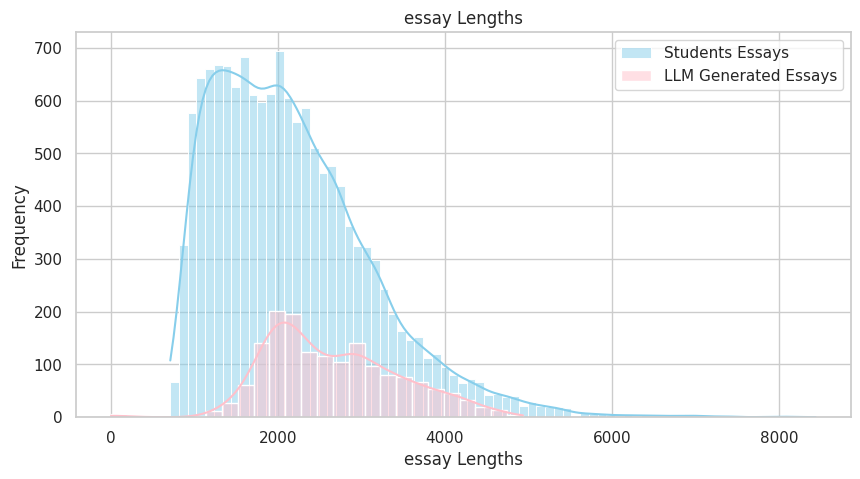

In [ ]:
RDizzl3_seven_v1['essay_length'] = RDizzl3_seven_v1['text'].apply(len)

sns.set(style="whitegrid", palette="deep")
plt.figure(figsize=(10, 5))

sns.histplot(RDizzl3_seven_v1[RDizzl3_seven_v1['label']==0]['essay_length'], color="skyblue", label='Students Essays', kde=True)
sns.histplot(RDizzl3_seven_v1[RDizzl3_seven_v1['label']==1]['essay_length'], color="pink", label='LLM Generated Essays', kde=True)

plt.title('essay Lengths')
plt.xlabel('essay Lengths')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* 위 데이터들과 유사한 분포

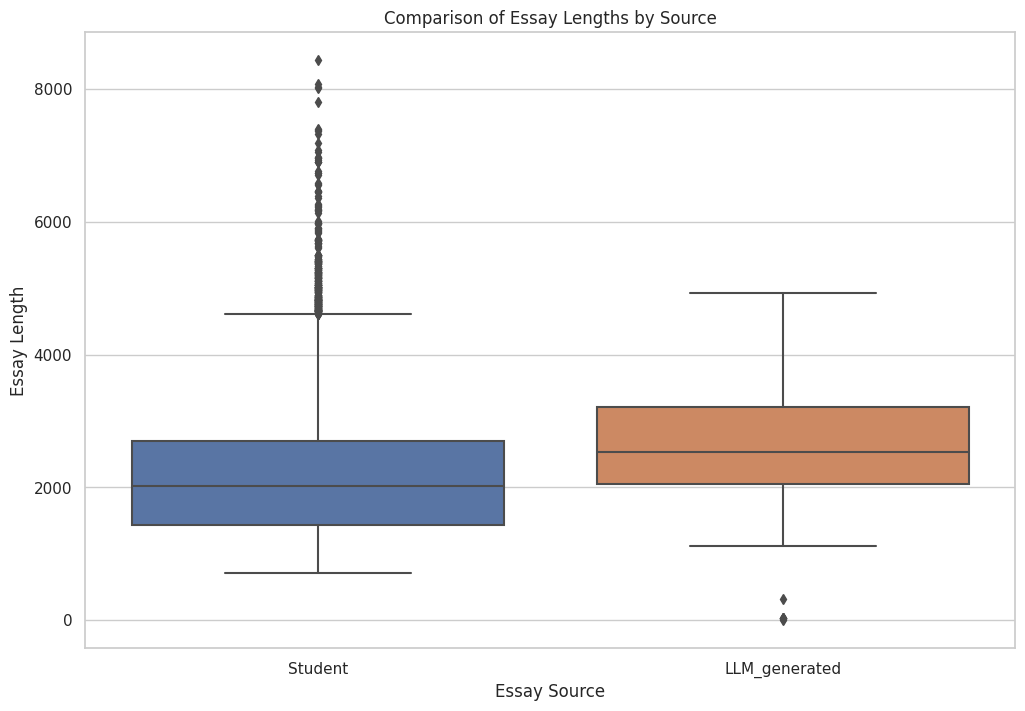

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='essay_length', data=RDizzl3_seven_v1)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student', 'LLM_generated'])
plt.show()

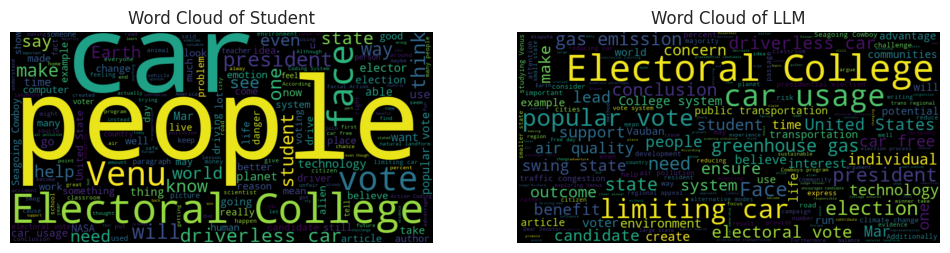

In [ ]:
text_student = ' '.join(RDizzl3_seven_v1[RDizzl3_seven_v1['label']==0]['text'])
text_llm = ' '.join(RDizzl3_seven_v1[RDizzl3_seven_v1['label']==1]['text'])

wordcloud_student = WordCloud(width=800, height=400, background_color='black').generate(text_student)
wordcloud_llm = WordCloud(width=800, height=400, background_color='black').generate(text_llm)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_student, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Student')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_llm, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of LLM')

plt.show()

* 워드클라우드도 비교하기 위해 사용해주었습니다.
* 이 데이터에서도 student가 더 눈에 띄는 단어가 많았기에 빈도수는 고려하지 않았습니다.

* **daigt-v2-train-dataset**
* DAIGT (Diverse Artificial Intelligence Generated Text)의 학습 데이터셋입니다. 여기에는 다양한 최신 모델들이 생성한 텍스트와 원본 에세이 텍스트가 포함


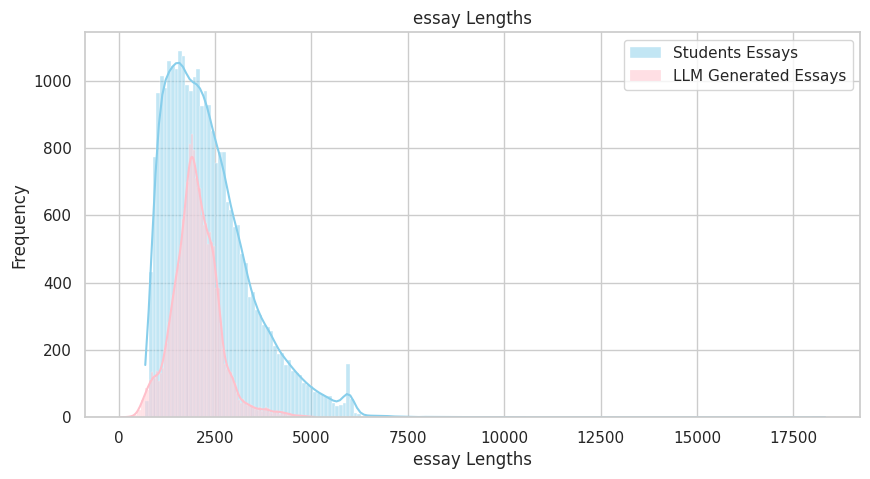

In [ ]:
daigtv2['essay_length'] = daigtv2['text'].apply(len)

sns.set(style="whitegrid", palette="deep")
plt.figure(figsize=(10, 5))

sns.histplot(daigtv2[daigtv2['label']==0]['essay_length'], color="skyblue", label='Students Essays', kde=True)
sns.histplot(daigtv2[daigtv2['label']==1]['essay_length'], color="pink", label='LLM Generated Essays', kde=True)

plt.title('essay Lengths')
plt.xlabel('essay Lengths')
plt.ylabel('Frequency')
plt.legend()
plt.show()

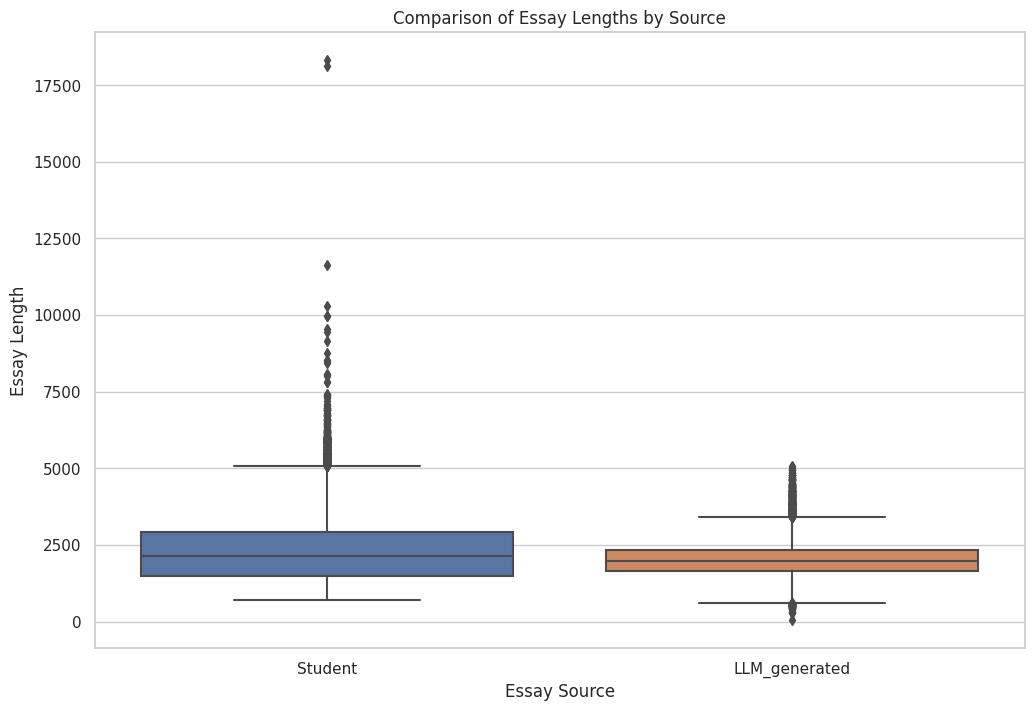

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='essay_length', data=daigtv2)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student', 'LLM_generated'])
plt.show()

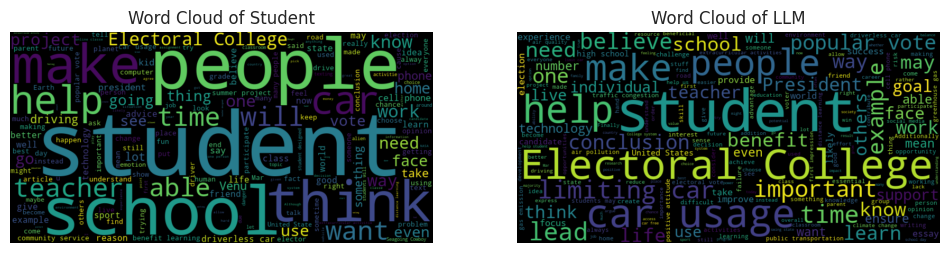

In [ ]:
text_student = ' '.join(daigtv2[daigtv2['label']==0]['text'])
text_llm = ' '.join(daigtv2[daigtv2['label']==1]['text'])

wordcloud_student = WordCloud(width=800, height=400, background_color='black').generate(text_student)
wordcloud_llm = WordCloud(width=800, height=400, background_color='black').generate(text_llm)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_student, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Student')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_llm, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of LLM')

plt.show()

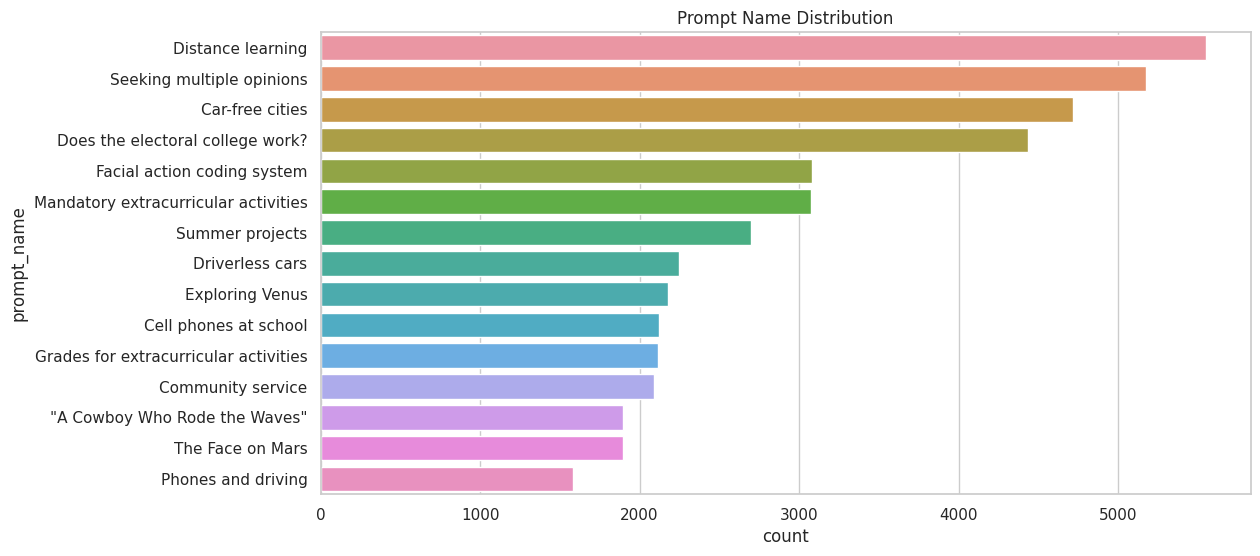

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 주제 빈도 분포 시각화
plt.figure(figsize=(12, 6))
sns.countplot(data=daigtv2, y='prompt_name', order=daigtv2['prompt_name'].value_counts().index)
plt.title('Prompt Name Distribution')
plt.show()

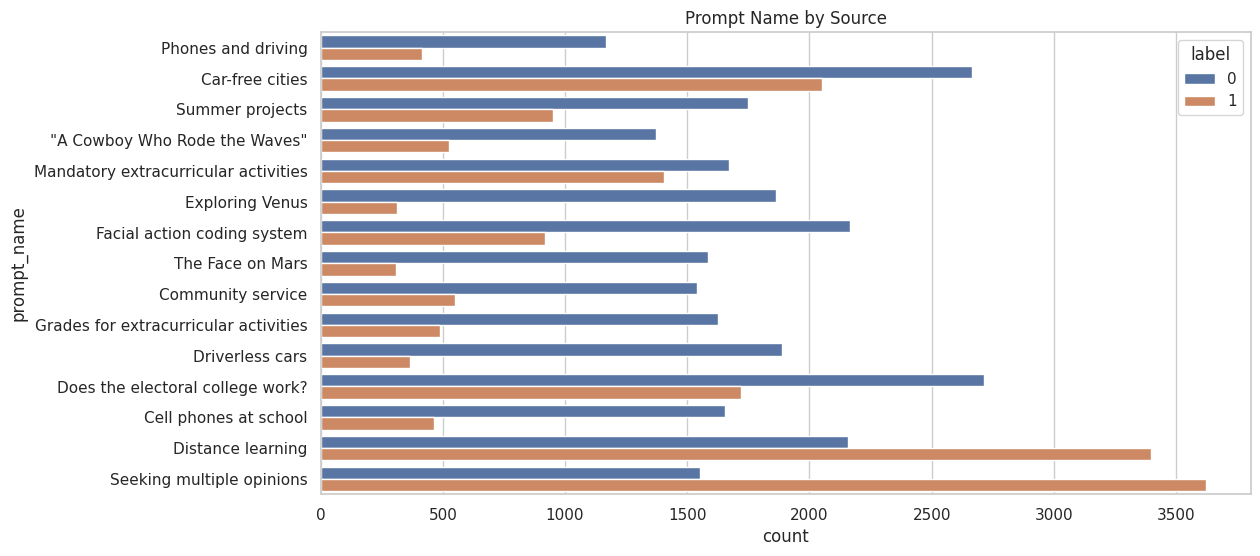

In [ ]:
# 주제와 작성자 간 관계 시각화
plt.figure(figsize=(12, 6))
sns.countplot(data=daigtv2, y='prompt_name', hue='label')
plt.title('Prompt Name by Source')
plt.show()
# 0이 사람, 1이 LLM

특정 주제에서는 학생과 LLM 모두 비슷한 분포를 보입니다. 예를 들어, "Distance learning", "Community service", "Grades for extracurricular activities" 같은 주제는 학생과 LLM 모두가 동일하거나 유사한 관심을 가졌습니다.
이런 결과는 주제가 두 그룹을 구분하는 데 중요한 기준이 되지 않음을 시사합니다.
주제 자체가 LLM과 학생을 나누는 기준으로 작용하기 어렵습니다.


## eda 분석 결과
사용하려는 데이터셋을 길이, 단어 빈도수를 살펴본 결과, 길이는 student text가 더 긴 경향을 보였으며 빈도수는 데이터셋에 따라 많은 차이를 보였습니다. (즉, 뭐가 더 많고 적음을 구분할 수 없었음)


## 데이터 전처리
새로 찾은 데이터셋과, 기존 데이터셋을 합쳐주고, 필요하지 않은 부분에 대해서는 전처리를 진행하였습니다.

In [ ]:
train=pd.concat([external_df, RDizzl3_seven_v1])

In [ ]:
print(train.head())

                                                text  label  essay_length
0  Some schools in United States ofter classes fr...      0        2454.0
1  Four-day work week, a remarkable idea to conse...      0        2698.0
2  Students and their families should consider an...      0        2567.0
3  Agree you will never grow if something beyond ...      0        1789.0
4  I think our character traits are formed by inf...      0        1119.0


<Axes: xlabel='label'>

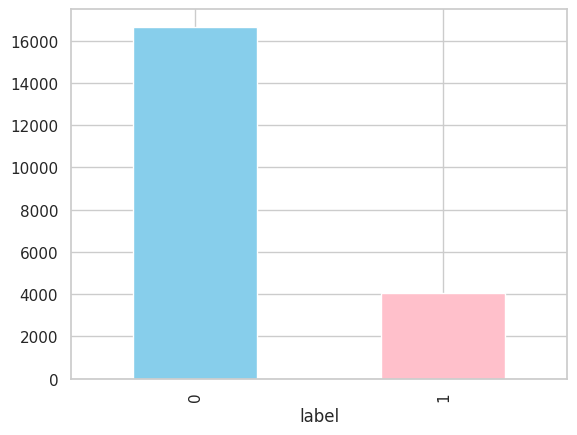

In [ ]:
train.value_counts("label").plot(kind="bar", color=["skyblue","pink"])

In [ ]:
RDizzl3_seven_v2 = pd.read_csv("/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v2.csv")

label_1_data = RDizzl3_seven_v2[RDizzl3_seven_v2['label'] == 1]

# 결과 확인
print(len(label_1_data))
print(label_1_data.tail())  # 마지막 5개의 행 출력
print(label_1_data.head())  # 첫 5개의 행 출력

3004
                                                    text  label
17246  Dear Senator,\n\nI am writing to you today to ...      1
17247  Dear Senator,\n\nI am writing to you today to ...      1
17248  Dear Senator,\n\nI am writing to you today to ...      1
17249  Dear Senator,\n\nI am writing to you today to ...      1
17250  Dear Senator,\n\nI am writing to you today to ...      1
                                                   text  label
704   This essay will analyze, discuss and prove one...      1
740   I strongly believe that the Electoral College ...      1
1262  Limiting car use causes pollution, increases c...      1
1378  Advantages of Limiting Car Usage \n\nLimiting ...      1
1379  Advantages of Limiting Car Usage\n\nLimiting c...      1


In [ ]:
deduplicated_data = label_1_data.drop_duplicates(subset=['text'])
print(len(deduplicated_data))
print(deduplicated_data.tail())
print(deduplicated_data.head())

3004
                                                    text  label
17246  Dear Senator,\n\nI am writing to you today to ...      1
17247  Dear Senator,\n\nI am writing to you today to ...      1
17248  Dear Senator,\n\nI am writing to you today to ...      1
17249  Dear Senator,\n\nI am writing to you today to ...      1
17250  Dear Senator,\n\nI am writing to you today to ...      1
                                                   text  label
704   This essay will analyze, discuss and prove one...      1
740   I strongly believe that the Electoral College ...      1
1262  Limiting car use causes pollution, increases c...      1
1378  Advantages of Limiting Car Usage \n\nLimiting ...      1
1379  Advantages of Limiting Car Usage\n\nLimiting c...      1


In [ ]:
daigtv2 = daigtv2.drop_duplicates(subset=['text'])

daigtv2.reset_index(drop=True, inplace=True)

daigtv2 = daigtv2[['text', 'label']]

print(daigtv2.head())

                                                text  label
0  Phones\n\nModern humans today are always on th...      0
1  This essay will explain if drivers should or s...      0
2  Driving while the use of cellular devices\n\nT...      0
3  Phones & Driving\n\nDrivers should not be able...      0
4  Cell Phone Operation While Driving\n\nThe abil...      0


In [ ]:
train=pd.concat([external_df, RDizzl3_seven_v1, label_1_data, daigtv2])

In [ ]:
print(train.head())
print(len(train))

                                                text  label
0  Some schools in United States ofter classes fr...      0
1  Four-day work week, a remarkable idea to conse...      0
2  Students and their families should consider an...      0
3  Agree you will never grow if something beyond ...      0
4  I think our character traits are formed by inf...      0
68585


<Axes: xlabel='label'>

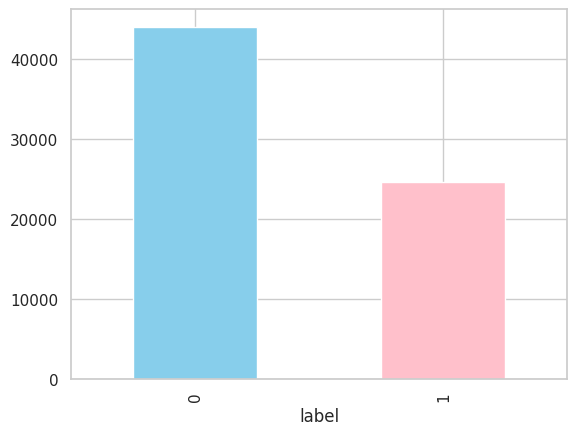

In [ ]:
train.value_counts("label").plot(kind="bar", color=["skyblue","pink"])

* 이전보다는 더 많아진 1 label 데이터

In [ ]:
y_train = train['label'].values

In [ ]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [ ]:
'''
from nltk.corpus import stopwords
import re

# Stopwords 설정
stop_words = set(stopwords.words('english'))

# 전처리 함수
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # 공백으로 나눈 후 stopwords 제거
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)
'''

In [ ]:
# 데이터프레임에 전처리 적용
# train['text'] = train['text'].apply(preprocess_text)
# test['text'] = test['text'].apply(preprocess_text)

In [ ]:
# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))


# Adding normalization and pre_tokenizer
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)



# Creating huggingface dataset object
dataset = Dataset.from_pandas(train[['text']])

def train_corp_iter():
    """
    A generator function for iterating over a dataset in chunks.
    """
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

# Training from iterator REMEMBER it's training on test set...
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)


tokenized_texts_test = []

# Tokenize test set with new tokenizer
for text in tqdm(test['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))


# Tokenize train set
tokenized_texts_train = []

for text in tqdm(train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/68585 [00:00<?, ?it/s]

In [ ]:
tokenized_texts_test[1]

['Ġb', 'b', 'b', 'Ġc', 'cc', 'Ġdd', 'd']

In [ ]:
# tokenized_texts_train[1]

In [ ]:
print(y_train)

[0 0 0 ... 1 1 1]


In [ ]:
def dummy(text):
    """
    A dummy function to use as tokenizer for TfidfVectorizer. It returns the text as it is since we already tokenized it.
    """
    return text

In [ ]:
# Fitting TfidfVectoizer on test set

vectorizer = TfidfVectorizer(
    ngram_range=(3, 5),
    lowercase=False,
    sublinear_tf=True,
    max_df=0.9,
    min_df=2,
    analyzer='word',
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None,
    strip_accents='unicode'
)

vectorizer.fit(tokenized_texts_test)

# Getting vocab
vocab = vectorizer.vocabulary_

print(vocab)


# Here we fit our vectorizer on train set but this time we use vocabulary from test fit.
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

{'b b Ġc': 0, 'b Ġc cc': 2, 'b b Ġc cc': 1}


23

In [ ]:
tf_train

<68585x3 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [ ]:
tf_train.shape

(68585, 3)

In [ ]:
tf_test.shape

(3, 3)

In [ ]:
print(tf_test)

  (0, 2)	0.5773502691896257
  (0, 1)	0.5773502691896257
  (0, 0)	0.5773502691896257
  (1, 2)	0.5773502691896257
  (1, 1)	0.5773502691896257
  (1, 0)	0.5773502691896257


In [ ]:
y_test = tf_test

In [ ]:
'''
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

xgb_model = XGBClassifier()
sgd_model = SGDClassifier()
logreg_model = LogisticRegression()
bayes_model = MultinomialNB()

xgb_param = {
    "n_estimators":[100, 200, 300],
    "max_depth":[6, 8, 10],
    "learning_rate":[0.01, 0.05, 0.1],
    "eval_metric":["rmse ","logloss ","auc"]
}

sgd_param = {
    "max_iter":[3000,5000,8000],
    "loss":["modified_huber", "hinge"],
    "learning_rate":["adaptive", "optimal"],
    "penalty":["l1", "l2", "elasticnet"],
    "alpha":[0.00001, 0.0001],
    "eta0":[0.01, 0.05, 0.1],
    "tol":[1e-4, 1e-5]
}

logreg_param = {
    "max_iter":[1000, 2000],
    "solver":['lbfgs','liblinear'],
    "penalty":["l1", "l2"],
}

bayes_param = {
    "alpha":[0.02, 0.1, 0.5]
}
'''

In [ ]:
# gscv_xgb = GridSearchCV(estimator = xgb_model, param_grid = xgb_param, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=-1)
# gscv_sgd = GridSearchCV(estimator = sgd_model, param_grid = sgd_param, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=-1)
# gscv_logreg = GridSearchCV(estimator = logreg_model, param_grid = logreg_param, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=-1)
# gscv_bayes = GridSearchCV(estimator = bayes_model, param_grid = bayes_param, scoring ='accuracy', cv = 2, refit=True, n_jobs=1, verbose=-1)

# gscv_xgb.fit(tf_train, y_train)
# gscv_sgd.fit(tf_train, y_train)
# gscv_logreg.fit(tf_train, y_train)
# gscv_bayes.fit(tf_train, y_train)

In [ ]:
# print('XGB 파라미터: ', gscv_xgb.best_params_)
# print('XGB 예측 정확도: {:.4f}\n'.format(gscv_xgb.best_score_))

# print('SGD 파라미터: ', gscv_sgd.best_params_)
# print('SGD 예측 정확도: {:.4f}\n'.format(gscv_sgd.best_score_))

# print('LOGLEG 파라미터: ', gscv_logreg.best_params_)
# print('LOGLEG 예측 정확도: {:.4f}\n'.format(gscv_logreg.best_score_))

# print('BAYES 파라미터: ', gscv_bayes.best_params_)
# print('BAYES 예측 정확도: {:.4f}'.format(gscv_bayes.best_score_))

XGB 파라미터:
 {'eval_metric': 'auc', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
SGD 파라미터:
 {'alpha': 1e-05, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'max_iter': 3000, 'penalty': 'l1', 'tol': 0.0001}
LOGLEG 파라미터:
 {'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
BAYES 파라미터:
 {'alpha': 0.02}


In [ ]:
from xgboost import XGBClassifier
import gc
from sklearn.linear_model import LogisticRegression

# Define the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_jobs=-1
)

bayes_model = MultinomialNB(alpha=0.02)

sgd_model = SGDClassifier(
    max_iter=3000,
    tol=0.0001,
    loss='modified_huber',
    alpha=1e-05,
    learning_rate='adaptive',
    eta0=0.01,
    penalty='l1'
)

logreg_model = LogisticRegression(
    max_iter=1000,
    penalty='l1',
    solver='liblinear'
)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('sgd', sgd_model),
        ('nb', bayes_model),
        ('logreg', logreg_model)
    ],
    weights=[0.4, 0.2, 0.2, 0.2],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(tf_train, y_train)


gc.collect()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


47

In [ ]:
final_preds = ensemble.predict_proba(tf_test)[:,1]

In [ ]:
sub['generated'] = final_preds
sub.to_csv('submission.csv', index=False)
sub

,id,generated
0,0000aaaa,0.378666
1,1111bbbb,0.378666
2,2222cccc,0.378666


모델별 예측 결과 확인

In [ ]:
xgb_model.fit(tf_train, y_train)
xgb_pred = xgb_model.predict(tf_test)
xgb_pred_probs = xgb_model.predict_proba(tf_test)[:, 1]

sub['generated'] = xgb_pred_probs
sub.to_csv('xgb_sub.csv', index=False)
sub

,id,generated
0,0000aaaa,0.409892
1,1111bbbb,0.409892
2,2222cccc,0.409892


In [ ]:
sgd_model.fit(tf_train, y_train)
sgd_pred = sgd_model.predict(tf_test)
sgd_pred_probs = sgd_model.predict_proba(tf_test)[:, 1]

sub['generated'] = sgd_pred_probs
sub.to_csv('sgd_sub.csv', index=False)
sub

,id,generated
0,0000aaaa,0.357725
1,1111bbbb,0.357725
2,2222cccc,0.357725


In [ ]:
bayes_model.fit(tf_train, y_train)
bayes_pred = bayes_model.predict(tf_test)
bayes_pred_probs = bayes_model.predict_proba(tf_test)[:, 1]

sub['generated'] = bayes_pred_probs
sub.to_csv('bayes_sub.csv', index=False)
sub

,id,generated
0,0000aaaa,0.357848
1,1111bbbb,0.357848
2,2222cccc,0.357848


In [ ]:
logreg_model .fit(tf_train, y_train)
logreg_pred = logreg_model .predict(tf_test)
logreg_pred_probs = logreg_model .predict_proba(tf_test)[:, 1]

sub['generated'] = logreg_pred_probs
sub.to_csv('logreg_sub.csv', index=False)
sub

,id,generated
0,0000aaaa,0.357863
1,1111bbbb,0.357863
2,2222cccc,0.357863
